In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import torch
import collections

## Load data

In [41]:
data = pd.read_csv('merged_sur_hrv_hr.csv') 
rrdata = pd.read_csv('rrdata.csv')

onehot_time = pd.get_dummies(data.time_of_day, prefix='OneHot')
data = data.drop(['time_of_day'], axis=1 )
data = pd.concat([onehot_time, data],axis=1) 

In [ ]:
data1 = data[['OneHot_day', 'OneHot_evening','OneHot_morning','OneHot_night','bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN',
       'S_COVID_BLUISH', 'class4']] 

In [44]:
from scipy.stats import iqr

N, T, C= 1480, 100, 4

##Point Features:
rr_features = pd.DataFrame({'rr_var' : []}) 
#Variance: the average of the squared differences from the mean
rr_features['rr_var'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).var(axis=1)
#Skewness, a measure of symmetry:
rr_features['rr_skew'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).skew(axis=1)
#Kurtosis: How heavily the tails of a distribution differ from the tails of a normal distribution:
rr_features['rr_kurt'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).kurtosis(axis=1)
#Max: 
rr_features['rr_max'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).max(axis=1)
#Min: 
rr_features['rr_min'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).min(axis=1)
#Median:
rr_features['rr_median'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).median(axis=1)
#Interquartile range (IQR):  the difference between the 75th and 25th percentile of the data.
rr_features['rr_IQR'] = iqr(rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1),axis=1)

ori_point_features = data1.drop(['class4'], axis=1) #original point features
Pointdata = torch.tensor(pd.concat([ori_point_features, rr_features],axis=1).values).to(torch.float) #(1480, 25)
Pointdata = (Pointdata-Pointdata.min(0, keepdim=True).values)/(Pointdata.max(0, keepdim=True).values - Pointdata.min(0, keepdim=True).values) #Rescale 

##Sequence Features:  
#rr_diff: Difference
rr_diff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).diff(periods=-1, axis=1)*(-1) 
rr_diff['rr99'] = 1/3*(rr_diff['rr98'] + rr_diff['rr97'] + rr_diff['rr96'])
rr_diff_tensor = torch.tensor(rr_diff.values).to(torch.float)
rr_diff_tensor = (rr_diff_tensor-rr_diff_tensor.min(0, keepdim=True).values)/(rr_diff_tensor.max(0, keepdim=True).values - rr_diff_tensor.min(0, keepdim=True).values) #Rescale 
rr_diff_tensor = rr_diff_tensor.reshape(N,T,1)
#rr_AbsMeanDiff = Absolute Different from the mean:
rr_AbsMeanDiff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1)
rr_AbsMeanDiff = abs(rr_AbsMeanDiff-rr_AbsMeanDiff.mean(0).values)
rr_AbsMeanDiff_tensor = torch.tensor(rr_AbsMeanDiff.values).to(torch.float)
rr_AbsMeanDiff_tensor = (rr_AbsMeanDiff_tensor-rr_AbsMeanDiff_tensor.min(0, keepdim=True).values)/(rr_AbsMeanDiff_tensor.max(0, keepdim=True).values - rr_AbsMeanDiff_tensor.min(0, keepdim=True).values) #Rescale 
rr_AbsMeanDiff_tensor = rr_AbsMeanDiff_tensor.reshape(N,T,1)
#Original seq features
rr = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1) #original seq features
rr_tensor = torch.tensor(rr.values).to(torch.float)
rr_tensor = (rr_tensor-rr_tensor.min(0, keepdim=True).values)/(rr_tensor.max(0, keepdim=True).values - rr_tensor.min(0, keepdim=True).values) #Rescale 
rr_tensor = rr_tensor.reshape(N,T,1)
#Combine
Seqdata = torch.cat((rr_tensor, rr_diff_tensor, rr_AbsMeanDiff_tensor), 2) #(1480, 100, 2)


##Class label:  
class_y = torch.tensor(data1['class4'].values)  #(N=1480, )

print("Pointdata:", Pointdata.shape, Pointdata.dtype)
print("Seqdata:", Seqdata.shape, Seqdata.dtype)
print("class_y:", class_y.shape, class_y.dtype)


## Sign of recovery

In [1447]:
data = pd.read_csv('merged_sur_hrv_hr.csv') 
rrdata = pd.read_csv('rrdata.csv')
tsdata = pd.concat([data['class4'], rrdata],axis=1) 

In [1448]:
recSign = []  
for i in range(tsdata.shape[0]):
    if (tsdata.loc[i, ['class4']]).item() == 3: 
        recSign.append(1)   #already recovered
        continue

    patienti = tsdata.loc[tsdata.user_code == tsdata.iloc[i]['user_code'], ]    
    if patienti.shape[0] > 7:  #valid days, patients have more than valid days' records are viewed as vaild 
        RecDaysi= patienti.loc[patienti.class4 == 3, 'day_after_test']
        if len(RecDaysi)!=0:
            minRecDayi = min(RecDaysi)
        else: 
            recSign.append(0)    #no recovered data(but have data) for this patient
            continue
            
        if (minRecDayi - tsdata.loc[i, ['day_after_test']]).item() <= 2 and (minRecDayi-tsdata.loc[i, ['day_after_test']]).item() >0: 
            recSign.append(1)   # sign of recovery 
        else:
            recSign.append(9)   # not in the 2-day interval of recovery record

    else:
        recSign.append(2)
            


In [1450]:
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tensorflow.keras.optimizers import Adam
from matplotlib import cm

### Evening data

In [1132]:
tsdata['recSign'] = recSign
SignData_E = pd.concat([tsdata.loc[tsdata.recSign == 31,], tsdata.loc[tsdata.recSign == 30,]]  , axis=0)
XSignData_E = SignData_E.drop(['class4','user_code','time_of_day','S_COVID_OVERALL','day_after_test','recSign'],axis=1)
XSignData_E = XSignData_E.to_numpy().reshape(XSignData_E.shape[0],XSignData_E.shape[1],1) 
#(n_ts, sz, d)   (number of time series, the maximum number of time points, the number of dimensions) 
ySData_E = SignData_E['recSign'].to_numpy()


rr_diff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).diff(periods=-1, axis=1)*(-1) 
rr_diff['rr99'] = 1/3*(rr_diff['rr98'] + rr_diff['rr97'] + rr_diff['rr96'])
rr_diff['recSign'] = recSign
rr_diff_SignData_E = pd.concat([rr_diff.loc[rr_diff.recSign == 31,], rr_diff.loc[rr_diff.recSign == 30,]]  , axis=0)
Xrr_diff_SignData_E = rr_diff_SignData_E.drop(['recSign'],axis=1)
Xrr_diff_SignData_E = Xrr_diff_SignData_E.to_numpy().reshape(Xrr_diff_SignData_E.shape[0],Xrr_diff_SignData_E.shape[1],1) 


rr_AbsMeanDiff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1)
rr_AbsMeanDiff = abs(rr_AbsMeanDiff-rr_AbsMeanDiff.mean(0).values)
rr_AbsMeanDiff['recSign'] = recSign
rr_AbsMeanDiff_SignData_E = pd.concat([rr_AbsMeanDiff.loc[rr_AbsMeanDiff.recSign == 31,], rr_AbsMeanDiff.loc[rr_AbsMeanDiff.recSign == 30,]], axis=0)
Xrr_AbsMeanDiff_SignData_E = rr_AbsMeanDiff_SignData_E.drop(['recSign'],axis=1)
Xrr_AbsMeanDiff_SignData_E = Xrr_AbsMeanDiff_SignData_E.to_numpy().reshape(Xrr_AbsMeanDiff_SignData_E.shape[0],Xrr_AbsMeanDiff_SignData_E.shape[1],1) 


all_SignData_E = np.concatenate((XSignData_E, Xrr_diff_SignData_E, Xrr_AbsMeanDiff_SignData_E), axis=2) 


# Smooth 
from statsmodels.nonparametric.smoothers_lowess import lowess
time = np.array(range(100))
XSignData_E_Smo = np.empty(XSignData_E.shape)
Xrr_diff_SignData_E_Smo = np.empty(Xrr_diff_SignData_E.shape)
Xrr_AbsMeanDiff_SignData_E_Smo = np.empty(Xrr_AbsMeanDiff_SignData_E.shape)

for i in range(XSignData_E_Smo.shape[0]):
    XSignData_E_Smo[i,:,0]=lowess(XSignData_E[i,:,0],np.arange(len(XSignData_E[i,:,0])),frac=0.5)[:,1]
for i in range(Xrr_diff_SignData_E_Smo.shape[0]):
    Xrr_diff_SignData_E_Smo[i,:,0]=lowess(Xrr_diff_SignData_E[i,:,0],np.arange(len(Xrr_diff_SignData_E[i,:,0])),frac=0.5)[:,1]
for i in range(Xrr_diff_SignData_E_Smo.shape[0]):
    Xrr_AbsMeanDiff_SignData_E_Smo[i,:,0]=lowess(Xrr_AbsMeanDiff_SignData_E[i,:,0],np.arange(len(Xrr_AbsMeanDiff_SignData_E[i,:,0])),frac=0.5)[:,1]

all_SignData_E_Smo = np.concatenate((XSignData_E_Smo, Xrr_diff_SignData_E_Smo, Xrr_AbsMeanDiff_SignData_E_Smo), axis=2) 


# Trend 
XSignData_E_Trd = np.empty(XSignData_E.shape)
Xrr_diff_SignData_E_Trd = np.empty(Xrr_diff_SignData_E.shape)
Xrr_AbsMeanDiff_SignData_E_Trd = np.empty(Xrr_AbsMeanDiff_SignData_E.shape)
from statsmodels.tsa.seasonal import seasonal_decompose
for i in range(XSignData_E_Trd.shape[0]):
    XSignData_E_Trd[i,:,0]=seasonal_decompose(XSignData_E[i,:,0], model='additive', freq=2).trend
for i in range(Xrr_diff_SignData_E_Smo.shape[0]):
    Xrr_diff_SignData_E_Trd[i,:,0]=seasonal_decompose(Xrr_diff_SignData_E[i,:,0], model='additive', freq=2).trend
for i in range(Xrr_AbsMeanDiff_SignData_E_Trd.shape[0]):
    Xrr_AbsMeanDiff_SignData_E_Trd[i,:,0]=seasonal_decompose(Xrr_AbsMeanDiff_SignData_E[i,:,0], model='additive', freq=2).trend
all_SignData_E_Trd = np.concatenate((XSignData_E_Trd, Xrr_diff_SignData_E_Trd, Xrr_AbsMeanDiff_SignData_E_Trd), axis=2) 



In [1133]:
# Trend then Smooth
XSignData_E_TS = np.empty(XSignData_E.shape)
Xrr_diff_SignData_E_TS = np.empty(Xrr_diff_SignData_E.shape)
Xrr_AbsMeanDiff_SignData_E_TS= np.empty(Xrr_AbsMeanDiff_SignData_E.shape) 
for i in range(XSignData_E_TS.shape[0]):
    XSignData_E_TS[i,1:-1,0]= lowess(XSignData_E_Trd[i,:,0],np.arange(len(XSignData_E[i,:,0])),frac=0.5)[:,1] 
for i in range(Xrr_diff_SignData_E_TS.shape[0]):
    Xrr_diff_SignData_E_TS[i,1:-1,0]= lowess(Xrr_diff_SignData_E_Trd[i,:,0],np.arange(len(Xrr_diff_SignData_E[i,:,0])),frac=0.5)[:,1] 
for i in range(Xrr_AbsMeanDiff_SignData_E_TS.shape[0]):
    Xrr_AbsMeanDiff_SignData_E_TS[i,1:-1,0]= lowess(Xrr_AbsMeanDiff_SignData_E_Trd[i,:,0],np.arange(len(Xrr_AbsMeanDiff_SignData_E[i,:,0])),frac=0.5)[:,1] 
all_SignData_E_TS = np.concatenate((XSignData_E_TS, Xrr_diff_SignData_E_TS, Xrr_AbsMeanDiff_SignData_E_TS), axis=2) 


In [ ]:
ySDataE = ySData_E
XSdataE= all_SignData_E_TS[:,1:-1,:]#all_SignData_E_Smo #XSignData_E_Smo, Xrr_diff_SignData_E_Smo, Xrr_AbsMeanDiff_SignData_E_Smo, XSignData_E, 
                          #Xrr_diff_SignData_E, Xrr_AbsMeanDiff_SignData_E
XSdataE = TimeSeriesScalerMinMax().fit_transform(XSdataE)  # Normalize the time series 

In [ ]:
shapelet_sizes = {8 : 2}  #each shapelet size (key): the number of such shapelets to be trained (value).
shp_clf_evening = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0000,
                            optimizer=Adam(lr=0.01),
                            max_iter=40000,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf_evening.fit(XSdataE, ySDataE)

/Users/muzheguo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Users/muzheguo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Users/muzheguo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Users/muzheguo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
 

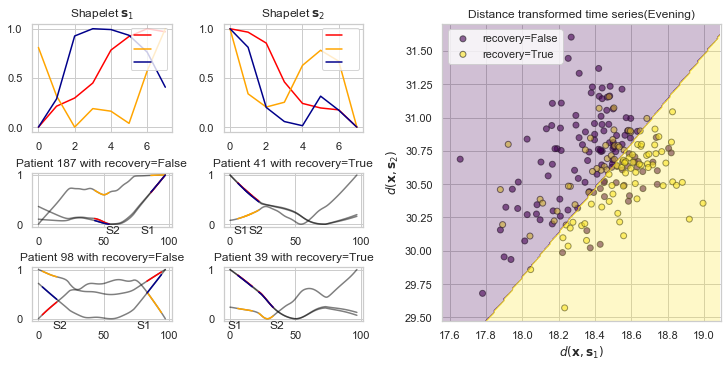

In [2001]:
distances = shp_clf_evening.transform(XSdataE).reshape((-1, 2))
weights, biases = shp_clf_evening.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('viridis', 2)
fig = plt.figure(constrained_layout=True, figsize = (10, 5))
gs = fig.add_gridspec(8, 4)
fig_ax1 = fig.add_subplot(gs[0:4, 0])
fig_ax2 = fig.add_subplot(gs[0:4, 1])

fig_ax3a = fig.add_subplot(gs[4:6, 0])
fig_ax3b = fig.add_subplot(gs[4:6, 1])
fig_ax3c = fig.add_subplot(gs[6:8, 0])
fig_ax3d = fig.add_subplot(gs[6:8, 1])

fig_ax4 = fig.add_subplot(gs[:, 2:]) 

#Plot our two shapelets on the left side
rescale_sl0 = TimeSeriesScalerMinMax().fit_transform(shp_clf_evening.shapelets_[0].reshape(1, -1, 3))  #######
rescale_sl1 = TimeSeriesScalerMinMax().fit_transform(shp_clf_evening.shapelets_[1].reshape(1, -1, 3))  #######

fig_ax1.plot(rescale_sl0[0,:,0],label='   ',c='red')       #######
fig_ax1.plot(rescale_sl0[0,:,1],label='   ',c='orange')#######
fig_ax1.plot(rescale_sl0[0,:,2],label='   ',c='darkblue')#######
fig_ax1.legend(fontsize="x-small",loc='upper right')#######
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(rescale_sl1[0,:,0],label='   ',c='red')#######
fig_ax2.plot(rescale_sl1[0,:,1],label='   ',c='orange')#######
fig_ax2.plot(rescale_sl1[0,:,2],label='   ',c='darkblue')#######
fig_ax2.legend(fontsize="x-small",loc='upper right')#######
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')


#fig.figure(figsize = (10,15))
HighProbF = shp_clf_evening.predict_proba(XSdataE[:,:,:])[:,1].argsort()[1:3].tolist()
HighProbT = shp_clf_evening.predict_proba(XSdataE[:,:,:])[:,0].argsort()[2:4].tolist()

mi = HighProbF + HighProbT 
classname = ['recovery=False','recovery=False','recovery=True','recovery=True']  
for i, subfig in enumerate([fig_ax3a,fig_ax3c, fig_ax3b,  fig_ax3d]):
    loc1 = shp_clf_evening.locate(XSdataE[:,:,:])[mi[i]][0] 
    loc2 = shp_clf_evening.locate(XSdataE[:,:,:])[mi[i]][1] 

    subfig.plot(range(len(XSdataE[mi[i],:,0])), XSdataE[mi[i],:,0],c='black',alpha=0.5)
    subfig.plot(range(len(XSdataE[mi[i],:,0])), XSdataE[mi[i],:,1],c='black',alpha=0.5)
    subfig.plot(range(len(XSdataE[mi[i],:,0])), XSdataE[mi[i],:,2],c='black',alpha=0.5)
    
    subfig.plot(range(loc1,loc1+12),XSdataE[mi[i],loc1:loc1+12,0],c='red')
    subfig.plot(range(loc1,loc1+12),XSdataE[mi[i],loc1:loc1+12,1],c='orange')
    subfig.plot(range(loc1,loc1+12),XSdataE[mi[i],loc1:loc1+12,2],c='darkblue')
    
    subfig.plot(range(loc2,loc2+12),XSdataE[mi[i],loc2:loc2+12,0],c='red')
    subfig.plot(range(loc2,loc2+12),XSdataE[mi[i],loc2:loc2+12,1],c='orange')
    subfig.plot(range(loc2,loc2+12),XSdataE[mi[i],loc2:loc2+12,2],c='darkblue')
    
    subfig.text(loc1-8, y=-0.2, s='S1', fontsize=12)  #######
    subfig.text(loc2+8, y=-0.2, s='S2', fontsize=12)  #######

    subfig.set_title('Patient %s with %s'%(mi[i], classname[i]))

# Create a scatter plot of the 2D distances for the time series of each class.
labelname = ['recovery=False','recovery=True']  
for i, y in enumerate(np.unique(ySDataE)):
    fig_ax4.scatter(distances[ySDataE == y][:, 0],
                    distances[ySDataE == y][:, 1],
                    c=[viridis(i / 1)] * np.sum(ySDataE == y),
                    edgecolors='k',
                    label='%s'%(labelname[i]),
                    alpha=0.6)

# Create a meshgrid of the decision boundaries
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin)/200),
                        np.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in np.c_[xx.ravel(), yy.ravel()]:
    Z.append([(biases[i] + weights[0][i]*x + weights[1][i]*y)>0 for i in range(1)])
Z = np.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend(loc='upper left')
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series(Evening)')
plt.show()

## Severe vs. mild patients

In [589]:
data = pd.read_csv('merged_sur_hrv_hr.csv')
rrdata = pd.read_csv('rrdata.csv')

In [597]:
plotdata = data[['user_code','time_of_day','bpm','meanrr','mxdmn','sdnn','rmssd','pnn50','amo','lf',
      'hf','vlf','lfhf','total_power','day_after_test','class4']]
plotdata = plotdata.copy()
plotdata = plotdata.loc[(plotdata["day_after_test"] > -100) & (plotdata["day_after_test"] < 100), ]

In [ ]:
numericData = plotdata[['bpm','meanrr','mxdmn','sdnn','rmssd','pnn50','amo','lf', 'hf','vlf','lfhf','total_power']]
numericData['lfp'] = numericData['lf']/(numericData['lf']+numericData['hf']+numericData['vlf'])

numericData = (numericData - numericData.min(0)) / (numericData.max(0) - numericData.min(0)) #Normalize 2 
Normalplotdata = pd.concat([plotdata[['user_code','time_of_day','day_after_test','class4']], numericData], axis=1)

Normalplotdata = Normalplotdata.loc[(Normalplotdata["day_after_test"] >= -5) & (plotdata["day_after_test"] <=16), ] 
Normalplotdata['Class'] = ['Mild' if Normalplotdata['class4'].iloc[i] in (0,3)
                         else 'Moderate' if Normalplotdata['class4'].iloc[i] in (1,) 
                         else 'Severe' for i in range(Normalplotdata.shape[0])]
Normalplotdata = pd.concat([Normalplotdata.loc[Normalplotdata.Class =="Mild",], 
                            Normalplotdata.loc[Normalplotdata.Class =='Severe',]],axis=0)

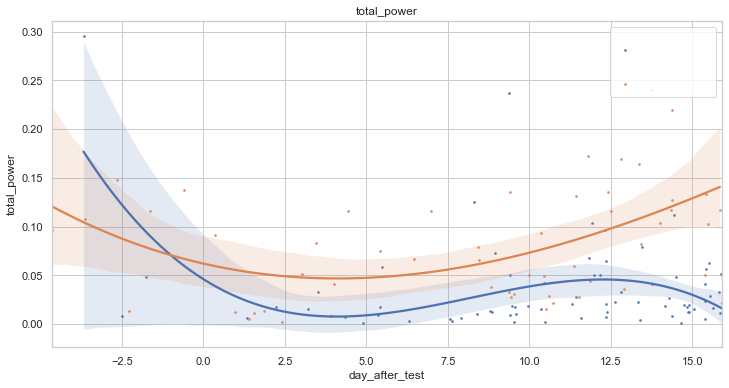

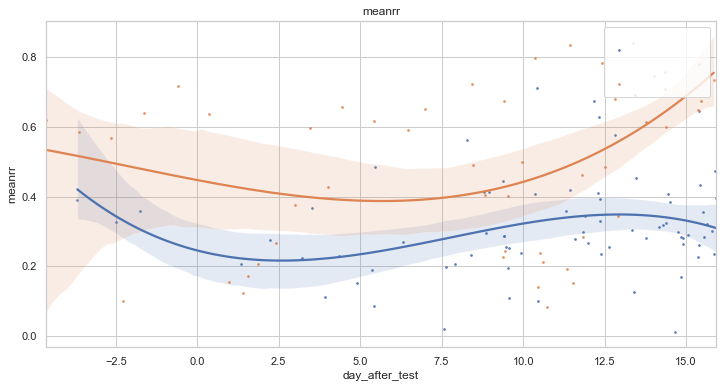

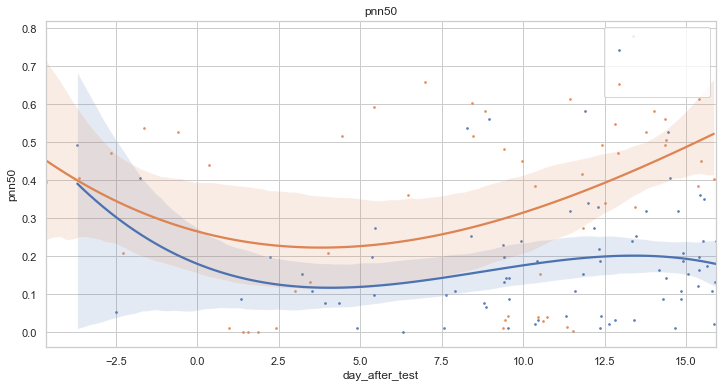

In [769]:
import seaborn as sns
for var in ['total_power','meanrr','pnn50']:
    ax = sns.regplot(x="day_after_test", y=var, data=Normalplotdata.loc[Normalplotdata.Class == 'Mild',],
                 scatter_kws={"s": 3},    #size = 1
                 scatter = True,
                 order=3, 
                 ci=95, label='        ')


    ax = sns.regplot(x="day_after_test", y=var, data=Normalplotdata.loc[Normalplotdata.Class == 'Severe',],
                 scatter_kws={"s": 3},    #size = 0 
                 scatter = True,
                 order=3, 
                 ci=95, label='        ')
    ax.figure.set_size_inches(12, 6)
    plt.legend(loc='upper right')
    plt.setp(ax.get_legend().get_texts(), fontsize='30') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='40') # for legend title
    plt.title(var)
    plt.show()